In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

### Code 6.13

In [2]:
from scipy.stats import norm, binom

# number of plants
N = 100

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# there is a 10% chance of fungus growth for the plants that have been treated; and 50% for those that haven't
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment, loc=0, size=N)

# the mean height for plants without fungus is 10 + 5 = 15; for those with fungus: 10 + 2 = 12
h1 = h0 + norm.rvs(loc=5 - 3 * fungus, scale=1, size=N)

df = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})
df.describe([0.055, 0.945])

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.789963,13.928633,0.500000,0.330000
std,2.027233,2.582353,0.502519,0.472582
min,5.172140,6.028414,0.000000,0.000000
5.5%,6.711866,9.590613,0.000000,0.000000
50%,9.569202,13.789943,0.500000,0.000000
94.5%,13.000930,17.840199,1.000000,1.000000
max,14.162102,19.773182,1.000000,1.000000


## Causal Diagram of Fungal Growth Simulation

$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$

## Model 1 

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
     p      & \sim \text{LogNormal}(0, 0.25)
\end{align*}
$$

### Code 6.14

In [3]:
from scipy.stats import lognorm


# mu=0 and sd=0.25 corresponds to s=0.25 and scale=np.exp(mu)
sim_p = lognorm.rvs(s=0.25, scale=np.exp(0), size=10000)

df_sim_p = pd.DataFrame({'sim_p': sim_p})
df_sim_p.describe([0.055, 0.945]).round(2)

,sim_p
count,10000.00
mean,1.04
std,0.26
min,0.39
5.5%,0.67
50%,1.00
94.5%,1.50
max,2.38


<AxesSubplot:ylabel='Density'>

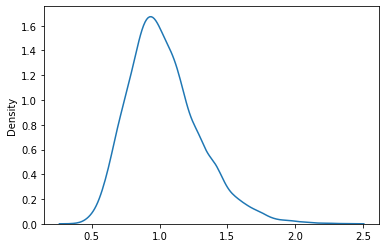

In [4]:
sns.kdeplot(sim_p)

### Code 6.15

In [5]:
with pm.Model() as m_6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_6 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [6]:
az.summary(trace_6_6, var_names=['p', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.402,0.020,1.371,1.434,0.000,0.000,6921.0,6921.0,6925.0,5947.0,1.0
sigma,1.968,0.142,1.740,2.189,0.002,0.001,5903.0,5831.0,5933.0,5231.0,1.0


## Model 2

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i + \beta_F \cdot F_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \beta_F & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 6.16

In [7]:
with pm.Model() as m_6_7:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    b_F = pm.Normal('b_F', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment'] + b_F * df['fungus']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_7 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_F, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


In [8]:
az.summary(trace_6_7, var_names=['a', 'b_T', 'b_F', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.508,0.027,1.465,1.551,0.000,0.000,3334.0,3334.0,3331.0,3749.0,1.0
b_T,0.007,0.031,-0.042,0.057,0.001,0.000,3409.0,3409.0,3412.0,4209.0,1.0
b_F,-0.303,0.033,-0.353,-0.247,0.001,0.000,3870.0,3870.0,3870.0,4422.0,1.0
sigma,1.303,0.095,1.156,1.453,0.001,0.001,4608.0,4574.0,4660.0,4344.0,1.0


## Discussion

The treatment variable seems to have very small association with the final height $h_i$ although we explicity set up the simulation data to make it so. Fungus seems to have had a negative effect on the final height, which is as expected. The problem here is that `fungus` is a consequence of the `treatment` and by including both of these as predictors in the model, we are asking the question: if we know whether there is fungal growth or not, what is the influence of soil treatment?

This is what we get if we omit the `fungus` variable.

### Code 6.17

In [9]:
with pm.Model() as m_6_8:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_8 = pm.sample(2000, tune=2000)

az.summary(trace_6_8, var_names=['a', 'b_T', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.326,0.025,1.287,1.366,0.000,0.000,3946.0,3946.0,3943.0,4831.0,1.0
b_T,0.162,0.037,0.103,0.219,0.001,0.000,3878.0,3829.0,3878.0,4461.0,1.0
sigma,1.808,0.133,1.610,2.028,0.002,0.001,5314.0,5314.0,5184.0,3619.0,1.0


## Using the Causal Graph

Recall that the causal graph of the simulated data looks like this:
$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$
When we condition on $F$, then this disconnects the path between $T$ and $H_1$ and these then become independent. This is what we observed in the model where we included both $F$ and $T$ as predictors. The list of conditional independencies are:

* $H_0 \perp \!\!\! \perp  F$
* $H_0 \perp \!\!\! \perp  T$
* $T \perp \!\!\! \perp H_1 \vert F$

The situation that we faced in the model that included both $F$ and $T$ is described by $T \perp \!\!\! \perp H_1 \vert F$. 

Now, the statement $H_0 \perp \!\!\! \perp  F$ states that $H_0$ is independent of $F$ provided we do not condition on anything. If we do in fact condition on some other variable, say, $H_1$ then the variables $H_0$ and $F$ are no longer independent. Let's suppose that we consider all plants in the experiment that achieved a final height $H_1$ of 13 units. Of these, those that were infected by the fungus reached this height only because they had a high initial height $H_0$ to begin with. Those that weren't affected by the fungus most likely had a lower initial height. Thus conditioning on $H_1$ leads to a positive association between $H_0$ and $F$. Similarly, there is a positive association between $H_0$ and $T$ if we condition on $H_1$.

## When Fungal Growth Does Not Influence Growth

We are considering the situation depicted by the causal graph:
$$
    H_0 \rightarrow  H_1 \leftarrow {\large \bigcirc} \hspace{-6mm} M \rightarrow F \leftarrow T 
$$

In [11]:
from scipy.stats import bernoulli

# number of plants
N = 1000

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# Mositure: 50-50 chance of moisture
M = bernoulli.rvs(p=0.5, size=N)

# there is a 10% chance of fungus growth for the plants that have been treated; and 50% for those that haven't
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment, loc=0, size=N)

# the mean height for plants without moisture is 10; for those with moisture: 10 + 3 = 13
h1 = h0 + norm.rvs(loc=5 + 3 * M, scale=1, size=N)

df_2 = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus, 'M': M})
df_2.describe([0.055, 0.945])

,h0,h1,treatment,fungus,M
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,10.045827,16.497411,0.50000,0.309000,0.487000
std,1.942993,2.607183,0.50025,0.462312,0.500081
min,2.351913,7.760676,0.00000,0.000000,0.000000
5.5%,7.077282,12.407555,0.00000,0.000000,0.000000
50%,10.051192,16.531685,0.50000,0.000000,0.000000
94.5%,13.168854,20.742363,1.00000,1.000000,1.000000
max,15.528726,24.613379,1.00000,1.000000,1.000000
